# 21. RNN with Bitcoin Price

In [1]:
import torch
import torch.nn as nn
from torch.autograd import Variable

import random
import numpy as np
import pandas as pd

import sklearn.metrics as metrics

In [2]:
import matplotlib.pyplot as plt
%matplotlib inline

## 21.1 Prepare Data

In [3]:
raw_data = pd.read_csv('data/bitcoin_data.csv')
raw_data.head()

,date,price
0,2013-01-02 0:00,13.40000
1,2013-01-04 0:00,13.48986
2,2013-01-06 0:00,13.52999
3,2013-01-08 0:00,13.83000
4,2013-01-10 0:00,14.32000


In [4]:
len(raw_data)

906

In [5]:
sample_data = raw_data[500:510]
sample_data

,date,price
500,2015-09-29 0:00,237.68
501,2015-10-01 0:00,238.98
502,2015-10-03 0:00,239.17
503,2015-10-05 0:00,239.22
504,2015-10-07 0:00,245.25
505,2015-10-09 0:00,244.78
506,2015-10-11 0:00,248.08
507,2015-10-13 0:00,249.58
508,2015-10-15 0:00,254.73
509,2015-10-17 0:00,269.07


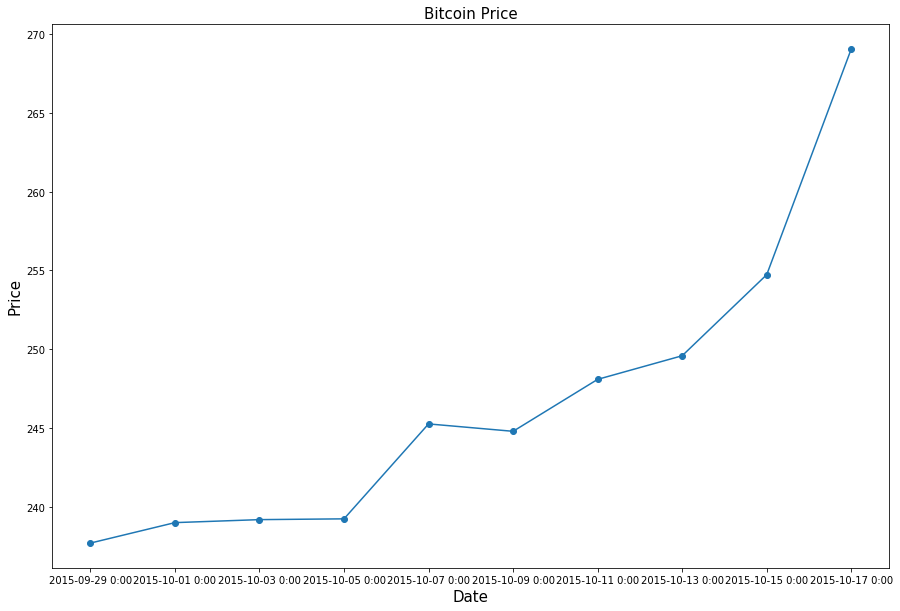

In [6]:
plt.figure(figsize=(15, 10))
plt.plot(sample_data['date'],sample_data['price'],'o-')
plt.title("Bitcoin Price", fontdict={'size':15})
plt.xlabel('Date', fontdict={'size':15})
plt.ylabel('Price', fontdict={'size':15})
plt.show()

In [7]:
data = raw_data['price']

## 21.2 Define Model

In [8]:
# Parameters:	
# input_size – The number of expected features in the input x
# hidden_size – The number of features in the hidden state h
# num_layers – Number of recurrent layers. E.g., setting num_layers=2 would mean stacking two RNNs together to form a stacked RNN, with the second RNN taking in outputs of the first RNN and computing the final results. Default: 1
# nonlinearity – The non-linearity to use. Can be either ‘tanh’ or ‘relu’. Default: ‘tanh’
# bias – If False, then the layer does not use bias weights b_ih and b_hh. Default: True
# batch_first – If True, then the input and output tensors are provided as (batch, seq, feature). Default: False
# dropout – If non-zero, introduces a Dropout layer on the outputs of each RNN layer except the last layer, with dropout probability equal to dropout. Default: 0
# bidirectional – If True, becomes a bidirectional RNN. Default: False

In [9]:
class RNN(nn.Module):
    def __init__(self, input_size, hidden_size, output_size, num_layers):
        super(RNN, self).__init__()
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.output_size = output_size
        self.num_layers = num_layers
        
        self.rnn = nn.RNN(input_size,hidden_size,num_layers, nonlinearity='relu')
        self.fc = nn.Linear(hidden_size, output_size)
        
    def forward(self, input, hidden):
        out,hidden = self.rnn(input.view(1,1,-1),hidden)
        out = self.fc(out.view(1,-1))
        return out,hidden

    def init_hidden(self):
        hidden = Variable(torch.zeros(self.num_layers, 1, self.hidden_size)).cuda()
        return hidden

In [10]:
input_window = 10
hidden_layer = 32
target_window = 1
vertical_layer = 2
step = 10

In [11]:
model = RNN(input_window, hidden_layer, target_window, vertical_layer).cuda()

## 21.3 Train Model

In [12]:
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
loss = nn.MSELoss()

In [13]:
num_epochs = 3

In [14]:
for epoch in range(num_epochs):
    
    sp = []
    for i in range(len(data)//input_window) :
        sp.append(random.randint(0, len(data)-2*input_window-step))
    random.shuffle(sp)
    
    for i in range(len(sp)) :
    
        hidden = model.init_hidden()

        cost = 0

        for pos in range(sp[i], sp[i] + step):
            X = Variable(torch.from_numpy(data[pos:pos+input_window].values).type(torch.FloatTensor)).cuda()
            y = torch.from_numpy(data[pos+input_window:pos+input_window+target_window].values).type(torch.FloatTensor).cuda()
            
            pre, hidden = model(X,hidden)
            cost += loss(pre,Variable(y).cuda())

        cost.backward()
        optimizer.step()

        if (i + 1) % 10 == 0 :
            print('Epoch [%d/%d], Iter [%d/%d] Loss: %.4f'
                     %(epoch+1, num_epochs, i + 1, len(sp), cost.data[0]))

Epoch [1/3], Iter [10/90] Loss: 3673212.5000
Epoch [1/3], Iter [20/90] Loss: 623504.5625
Epoch [1/3], Iter [30/90] Loss: 55020.9805
Epoch [1/3], Iter [40/90] Loss: 44211.5391
Epoch [1/3], Iter [50/90] Loss: 1220468.3750
Epoch [1/3], Iter [60/90] Loss: 244552.1562
Epoch [1/3], Iter [70/90] Loss: 30844.3301
Epoch [1/3], Iter [80/90] Loss: 128299672.0000
Epoch [1/3], Iter [90/90] Loss: 357671.4375
Epoch [2/3], Iter [10/90] Loss: 303620.4375
Epoch [2/3], Iter [20/90] Loss: 621373.5625
Epoch [2/3], Iter [30/90] Loss: 3837586.2500
Epoch [2/3], Iter [40/90] Loss: 8685631.0000
Epoch [2/3], Iter [50/90] Loss: 2513585.2500
Epoch [2/3], Iter [60/90] Loss: 1127547.8750
Epoch [2/3], Iter [70/90] Loss: 3469789.0000
Epoch [2/3], Iter [80/90] Loss: 1368381.7500
Epoch [2/3], Iter [90/90] Loss: 1081591.2500
Epoch [3/3], Iter [10/90] Loss: 3313621.5000
Epoch [3/3], Iter [20/90] Loss: 1305597.0000
Epoch [3/3], Iter [30/90] Loss: 4271.6289
Epoch [3/3], Iter [40/90] Loss: 5897433.0000
Epoch [3/3], Iter [50/

## 21.4 Test Model

In [15]:
model.eval()

hidden = model.init_hidden()
pre = []

for i in range(len(data)-input_window) :
    X = Variable(torch.from_numpy(data[i:i+input_window].values).type(torch.FloatTensor)).cuda()
    y, hidden = model(X, hidden)
    pre.append(y.data[0].cpu().numpy())

pre = np.concatenate((raw_data['price'][0:input_window], pre), axis=None)

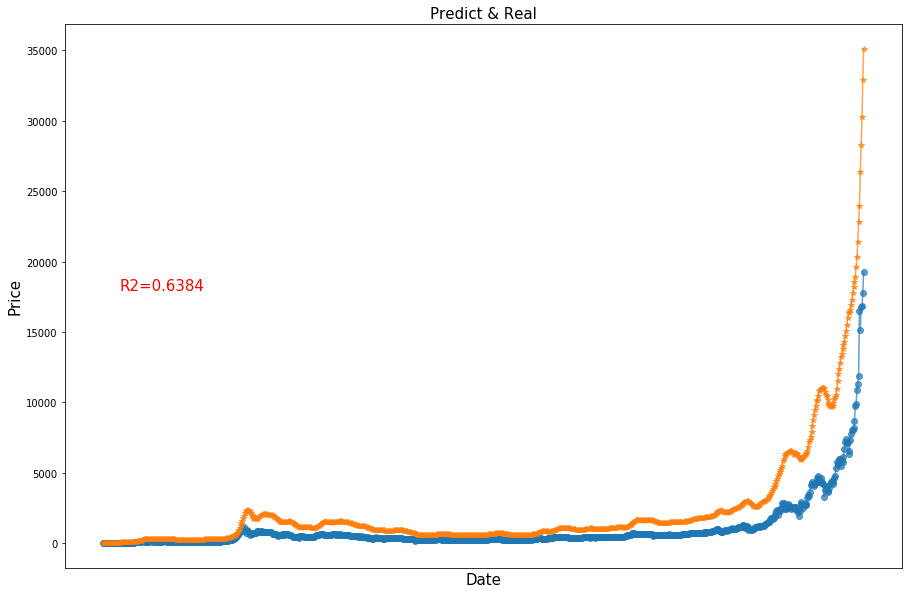

In [16]:
plt.figure(figsize=(15, 10))

plt.plot(raw_data['date'],raw_data['price'],'o-', alpha=0.7)
plt.plot(raw_data['date'],pre, '*-', alpha=0.7)

plt.title("Predict & Real", fontdict={'size':15})

plt.xlabel('Date', fontdict={'size':15})
plt.xticks([])

plt.ylabel('Price', fontdict={'size':15})

plt.text(20, 18000, 'R2=%.4f' % metrics.r2_score(pre, raw_data['price']), fontdict={'size':15, 'color':'red'})

plt.show()